In [1]:
from data.mnist_loader import load_data_wrapper
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Getting data

In [45]:
train_data, validation_data, test_data = load_data_wrapper()
train_data = train_data + test_data

In [46]:
X_train, y_train = list(zip(*train_data))
X_val, y_val = list(zip(*validation_data))

In [49]:
X_train = [x.reshape(784) for x in X_train]
y_train = [np.argmax(yi) for yi in y_train]

X_val = [x.reshape(784) for x in X_val]

### Model selection

In [5]:
mlp = MLPClassifier(solver='sgd', learning_rate='constant', activation='relu', random_state=1)

In [6]:
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,)],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 300],
    'batch_size': [32, 64, 128]
}

In [7]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

c:\Users\crsj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\crsj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\crsj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\crsj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\crsj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=1, solver='sgd'),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [(32,), (64,), (128,)],
                         'max_iter': [100, 200, 300]},
             scoring='accuracy')

In [61]:
best_parameters

{'alpha': 0.01, 'batch_size': 128, 'hidden_layer_sizes': (64,), 'max_iter': 100}


In [8]:
best_parameters = grid_search.best_params_

mlp = MLPClassifier(solver='sgd', learning_rate='constant', activation='relu', random_state=1, **best_parameters)

In [27]:
grid_search.best_score_

0.7960166666666667

### Training

In [53]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
grad_norms = []

for i in range(mlp.max_iter):

    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

    grad_norm = np.linalg.norm(mlp.coefs_[0])
    grad_norms.append(grad_norm) # gradient at each step

    train_loss = mlp.loss_
    train_losses.append(train_loss) # train loss
    
    test_pred = mlp.predict(X_val)
    mean_squared_error = np.mean((test_pred - y_val)**2)
    val_losses.append(mean_squared_error) # test loss

    train_acc = mlp.score(X_train, y_train) 
    train_accs.append(train_acc) # train accuracy

    val_acc = mlp.score(X_val, y_val)
    val_accs.append(val_acc) # test accuracy

### Model analysis

#### Filters: Visualize the filters learned by the model to see what kind of patterns the model is looking for in the input.

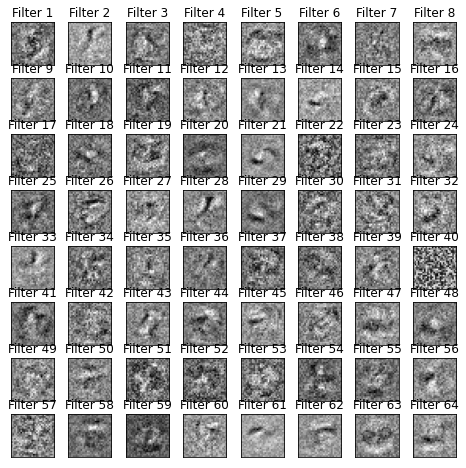

In [54]:
weights = mlp.coefs_[0]

# Create figure and axis objects
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot filters
for i, ax in enumerate(axes.flat):
    filter = weights[:, i]
    image = filter.reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Filter {i+1}')

#### Gradient Norm: Plot the gradient norm over time to see if the gradients are exploding or vanishing.

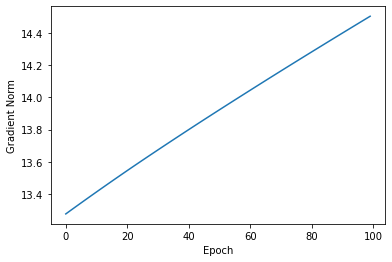

In [55]:
plt.plot(grad_norms, label='Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.show()

#### Training and Validation Loss: Plot the training and validation loss over time to see how the model is performing. This can help you determine if the model is overfitting or underfitting.

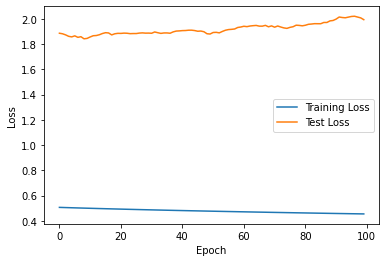

In [56]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training and Validation Accuracy: Plot the training and validation accuracy over time to see how well the model is classifying the MNIST digits.

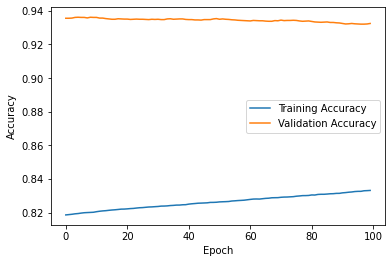

In [57]:
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion Matrix: A confusion matrix can help you understand how the model is misclassifying digits. It shows the number of true positive, false positive, true negative, and false negative predictions.

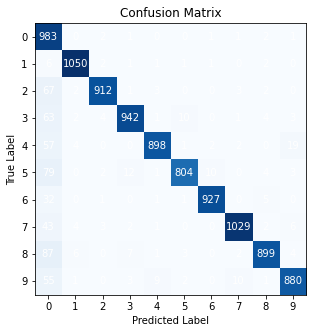

In [60]:
y_pred = mlp.predict(X_val)

conf_matrix = confusion_matrix( y_val,y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
for i in range(10):
    for j in range(10):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()